In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


# TS
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.pipeline import Pipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.preprocessing import OneHotEncoder

# User Imports
import sys
sys.path.append("..")
from src import util

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
load = util.read_load("../data/load_hist_data.csv", method="classification")
load.head()

,ds,y,is_max
0,2005-01-01 00:00:00,857.0,0
1,2005-01-01 01:00:00,825.0,0
2,2005-01-01 02:00:00,800.0,0
3,2005-01-01 03:00:00,794.0,0
4,2005-01-01 04:00:00,802.0,0


In [3]:
weather = util.read_weather("../data/weather_data.csv")
weather.station_id = weather.station_id.apply(lambda x: f"station_{str(x).zfill(2)}")
weather_wide = weather.pivot(index='ds', columns='station_id', values='temperature')
weather_wide.head()

station_id,station_01,station_02,station_03,station_04,station_05,station_06,station_07,station_08,station_09,station_10,...,station_19,station_20,station_21,station_22,station_23,station_24,station_25,station_26,station_27,station_28
ds,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,43,46,40,47,48,46,44,52,45,42,...,39,50,43,45,50,47,41,47,47,45
2005-01-01 01:00:00,41,46,38,46,48,45,51,50,42,41,...,41,49,43,46,47,47,45,47,47,45
2005-01-01 02:00:00,40,46,37,45,45,45,49,48,43,40,...,43,50,41,45,45,46,45,46,46,43
2005-01-01 03:00:00,39,46,37,47,48,48,45,50,42,39,...,43,49,41,43,45,44,45,47,47,44
2005-01-01 04:00:00,38,46,37,44,48,49,43,50,42,38,...,43,49,39,43,43,45,45,47,46,44


In [4]:
# Date Time Features

dtf = DateTimeFeatures(ts_freq='H', manual_selection=['month_of_year', 'day_of_week', 'hour_of_day'])
time_ohe = OneHotEncoder(handle_unknown='ignore')

pipe = Pipeline([('dt_feats', dtf), ('dt_ohe', time_ohe)])
X_dtf = pipe.fit_transform(weather_wide)
weather_datetime_feats = pd.DataFrame(X_dtf.todense())
weather_datetime_feats.columns = [f'dtf_{str(i).zfill(2)}' for i in range(len(weather_datetime_feats.columns))]
weather_datetime_feats.index = weather_wide.index
weather_datetime_feats.head()

/home/allen/Documents/code/energy_meter/np_env/lib/python3.9/site-packages/sktime/transformations/base.py:583: UserWarning: Level of selected dummy variable  lower level than base ts_frequency.
  Xt = self._transform(X=X_inner, y=y_inner)


,dtf_00,dtf_01,dtf_02,dtf_03,dtf_04,dtf_05,dtf_06,dtf_07,dtf_08,dtf_09,...,dtf_33,dtf_34,dtf_35,dtf_36,dtf_37,dtf_38,dtf_39,dtf_40,dtf_41,dtf_42
ds,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 01:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 02:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 03:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 04:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
## Window Features
kwargs = {
    "lag_feature": {
        "lag": [24],
        "mean": [[-24, 24]],
        "std": [[-24, 24]],
    },
    "target_cols": [f"station_{str(i).zfill(2)}" for i in range(1,29)],
}

ws = WindowSummarizer(**kwargs)

xt = ws.fit_transform(weather_wide).interpolate(method='bfill').interpolate(method='ffill')
xt.head(48)


station_id,station_01_lag_24,station_01_mean_-24_24,station_01_std_-24_24,station_02_lag_24,station_02_mean_-24_24,station_02_std_-24_24,station_03_lag_24,station_03_mean_-24_24,station_03_std_-24_24,station_04_lag_24,...,station_25_std_-24_24,station_26_lag_24,station_26_mean_-24_24,station_26_std_-24_24,station_27_lag_24,station_27_mean_-24_24,station_27_std_-24_24,station_28_lag_24,station_28_mean_-24_24,station_28_std_-24_24
ds,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 01:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 02:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 03:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 04:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 05:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 06:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 07:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528
2005-01-01 08:00:00,43.0,55.291667,9.219446,46.0,51.583333,6.736769,40.0,48.958333,8.774861,47.0,...,8.910180,47.0,53.541667,10.479708,47.0,54.958333,9.410813,45.0,52.208333,8.637528


In [6]:
X_all = pd.concat([weather_wide, xt, weather_datetime_feats], axis=1)
X_all

,station_01,station_02,station_03,station_04,station_05,station_06,station_07,station_08,station_09,station_10,...,dtf_33,dtf_34,dtf_35,dtf_36,dtf_37,dtf_38,dtf_39,dtf_40,dtf_41,dtf_42
ds,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:00:00,43,46,40,47,48,46,44,52,45,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 01:00:00,41,46,38,46,48,45,51,50,42,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 02:00:00,40,46,37,45,45,45,49,48,43,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 03:00:00,39,46,37,47,48,48,45,50,42,39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01 04:00:00,38,46,37,44,48,49,43,50,42,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-31 19:00:00,37,37,31,36,43,37,40,42,21,39,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2008-12-31 20:00:00,34,36,29,34,41,36,38,40,19,37,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2008-12-31 21:00:00,34,36,28,33,39,35,36,38,19,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
cols_with_na = X_all.apply(lambda row: row.isna().sum())
cols_with_na[cols_with_na > 0]

Series([], dtype: int64)

In [48]:
target_col = 'is_max'
class_data = pd.merge(load[['ds', 'is_max']], X_all.reset_index(), on='ds', how='outer')
class_data.set_index('ds', inplace=True)

mod_data = class_data[:'2007-12-31 23:00:00']
mod_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(mod_data, test_size=0.2)

train_X = train_data.drop(columns=target_col)
train_y = train_data[target_col]

test_X = test_data.drop(columns=target_col)
test_y = test_data[target_col]

deploy_X = class_data['2008-01-01 00:00:00':].drop(columns=target_col)

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SimpleImputer(), SVC(gamma='auto', probability=True))
clf.fit(train_X, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('svc', SVC(gamma='auto', probability=True))])

In [24]:
test_probs = clf.predict_proba(test_X)
from sklearn.metrics import mean_squared_error

test_error = mean_squared_error(y_true = test_y, y_pred = test_probs[:, 1])
test_error


0.035113906820425166

## Deploy Model

clf.predict_proba(deploy_X)

In [49]:
deploy_prob_hats = clf.predict_proba(deploy_X)

In [50]:
preds = pd.DataFrame({'ds': deploy_X.index, 'prob_hat': deploy_prob_hats[:,1]})
preds['date'] = preds.ds.dt.date
preds['hour'] = preds.ds.dt.hour
preds

,ds,prob_hat,date,hour
0,2008-01-01 00:00:00,0.016912,2008-01-01,0
1,2008-01-01 01:00:00,0.018712,2008-01-01,1
2,2008-01-01 02:00:00,0.016278,2008-01-01,2
3,2008-01-01 03:00:00,0.016273,2008-01-01,3
4,2008-01-01 04:00:00,0.014981,2008-01-01,4
...,...,...,...,...
8778,2008-12-31 19:00:00,0.045993,2008-12-31,19
8779,2008-12-31 20:00:00,0.067510,2008-12-31,20
8780,2008-12-31 21:00:00,0.039948,2008-12-31,21
8781,2008-12-31 22:00:00,0.037389,2008-12-31,22


Date                      False
Hour                      False
Daily Peak Probability    False
dtype: bool

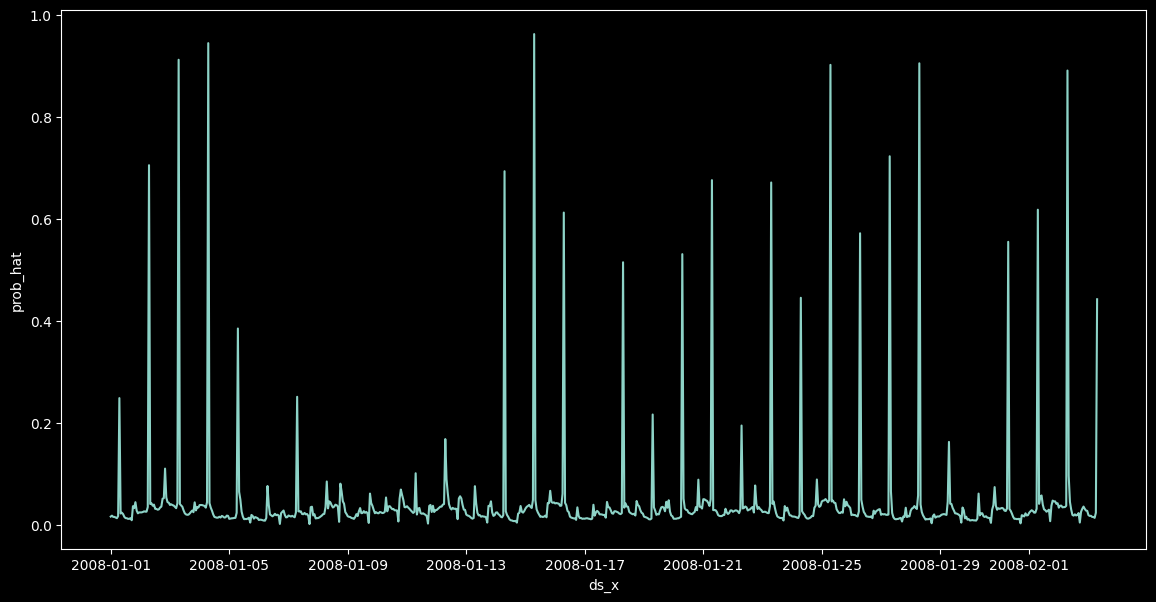

In [55]:
submission = pd.read_csv("../data/probability_estimates-original.csv")
submission['ds'] = pd.to_datetime(submission.Date)
submission['ds'] = pd.to_datetime(submission.apply(lambda row: f"{row['ds'].strftime('%Y-%m-%d')} {str(row['Hour']-1).zfill(2)}:00:00", axis=1))
submission['date'] = submission.ds.dt.date
submission['hour'] = submission.ds.dt.hour
submission = submission.merge(preds, on=['date', 'hour'], how='left')
submission['Daily Peak Probability'] = submission.prob_hat
sns.lineplot(data=submission.head(800), x='ds_x', y='prob_hat')
submission = submission[['Date', 'Hour', 'Daily Peak Probability']]
print(submission.isna().any())
submission.to_csv("")